# Processing ERA5 data in NetCDF Format

This notebook demonstrates how to work with the ECMWF ERA5 reanalysis available as part of the AWS Public Dataset Program (https://registry.opendata.aws/ecmwf-era5/).

This notebook utilizes Amazon SageMaker & AWS Fargate for providing an environment with a Jupyter notebook and Dask cluster. There is an example AWS CloudFormation template available at https://github.com/awslabs/amazon-asdi/tree/main/examples/dask for quickly creating this environment in your own AWS account to run this notebook.

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

In [2]:
import sys
!{sys.executable} -m pip install graphviz
import graphviz

## Scale out Dask Workers

In [3]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
if len(clusters) > 1:
    print("Please manually select your cluster")
cluster = clusters[0]
cluster

'arn:aws:ecs:us-east-1:282832549180:cluster/dask-environment-Fargate-Dask-Cluster'

You will need to update the `--cluster` option in the comamnd below to make your cluster name from above

In [4]:
numWorkers=48
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

# Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

In [5]:
client = Client('Dask-Scheduler.local-dask:8786')
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 48 Cores: 96 Memory: 336.00 GB


## Open an Example File and Check the Native Chunking

We want to chunk in a similar way for maximum performance

In [28]:
fs = s3fs.S3FileSystem(anon=True)
fs.ls('era5-pds/2020/01/data')

['era5-pds/2020/01/data/air_pressure_at_mean_sea_level.nc',
 'era5-pds/2020/01/data/air_temperature_at_2_metres.nc',
 'era5-pds/2020/01/data/air_temperature_at_2_metres_1hour_Maximum.nc',
 'era5-pds/2020/01/data/air_temperature_at_2_metres_1hour_Minimum.nc',
 'era5-pds/2020/01/data/dew_point_temperature_at_2_metres.nc',
 'era5-pds/2020/01/data/eastward_wind_at_100_metres.nc',
 'era5-pds/2020/01/data/eastward_wind_at_10_metres.nc',
 'era5-pds/2020/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc',
 'era5-pds/2020/01/data/lwe_thickness_of_surface_snow_amount.nc',
 'era5-pds/2020/01/data/northward_wind_at_100_metres.nc',
 'era5-pds/2020/01/data/northward_wind_at_10_metres.nc',
 'era5-pds/2020/01/data/precipitation_amount_1hour_Accumulation.nc',
 'era5-pds/2020/01/data/sea_surface_temperature.nc',
 'era5-pds/2020/01/data/sea_surface_wave_from_direction.nc',
 'era5-pds/2020/01/data/sea_surface_wave_mean_period.nc',
 'era5-pds/2020/01/data/s

In [29]:
url = 's3://era5-pds/2010/01/data/air_temperature_at_2_metres.nc'
ncfile = fsspec.open(url)
ds = xr.open_dataset(ncfile.open())

ds.air_temperature_at_2_metres.encoding

{'chunksizes': (24, 100, 100),
 'fletcher32': False,
 'shuffle': True,
 'zlib': True,
 'complevel': 4,
 'source': '<File-like object S3FileSystem, era5-pds/2010/01/data/air_temperature_at_2_metres.nc>',
 'original_shape': (744, 721, 1440),
 'dtype': dtype('<f4'),
 '_FillValue': array([9.96921e+36], dtype=float32)}

In [30]:
ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 744, lat: 721, lon: 1440)>
[772450560 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time0    (time0) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
Attributes:
    least_significant_digit:  [1]
    standard_name:            air_temperature
    units:                    K
    long_name:                2 metre temperature
    nameECMWF:                2 metre temperature
    shortNameECMWF:           2t
    nameCDM:                  2_metre_temperature_surface
    product_type:             analysis

## Open 2-m air temperature as a single dataset

In [31]:
start_year = 2015
end_year = 2020
years = list(np.arange(start_year, end_year+1, 1))
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
file_pattern = 's3://era5-pds/{year}/{month}/data/air_temperature_at_2_metres.nc'

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    return fs.open(path)

files_mapper = [s3open(file_pattern.format(year=year,month=month)) for year in years for month in months]

In [44]:
%%time

ds = xr.open_mfdataset(files_mapper, engine='h5netcdf', chunks={'lon':400,'lat':400,'time0':720}, concat_dim='time0', combine='nested', coords='minimal', compat='override', parallel=True)

CPU times: user 1.1 s, sys: 895 ms, total: 1.99 s
Wall time: 4.26 s


In [45]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 218.48



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lat: 721, lon: 1440, time0: 52608)
Coordinates:
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                        (time0) datetime64[ns] 2015-01-01 ... 2020-1...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(720, 400, 400), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

In [47]:
ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 52608, lat: 721, lon: 1440)>
dask.array<concatenate, shape=(52608, 721, 1440), dtype=float32, chunksize=(720, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time0    (time0) datetime64[ns] 2015-01-01 ... 2020-12-31T23:00:00
Attributes:
    least_significant_digit:  [1]
    standard_name:            air_temperature
    units:                    K
    long_name:                2 metre temperature
    nameECMWF:                2 metre temperature
    shortNameECMWF:           2t
    nameCDM:                  2_metre_temperature_surface
    product_type:             analysis

## Convert units to C from K

In [48]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15)
ds.air_temperature_at_2_metres.attrs['units'] = 'C'

## Calculate the mean 2-m air temperature for all times

In [49]:
# calculates the mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `persist` method:

In [50]:
temp_mean

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(400, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

In [51]:
#temp_mean.data.visualize()

In [52]:
temp_mean = temp_mean.persist()
progress(temp_mean)

VBox()

### Plot Average Surface Temperature

Text(0.5, 1.0, '2015-2020 Mean 2-m Air Temperature')

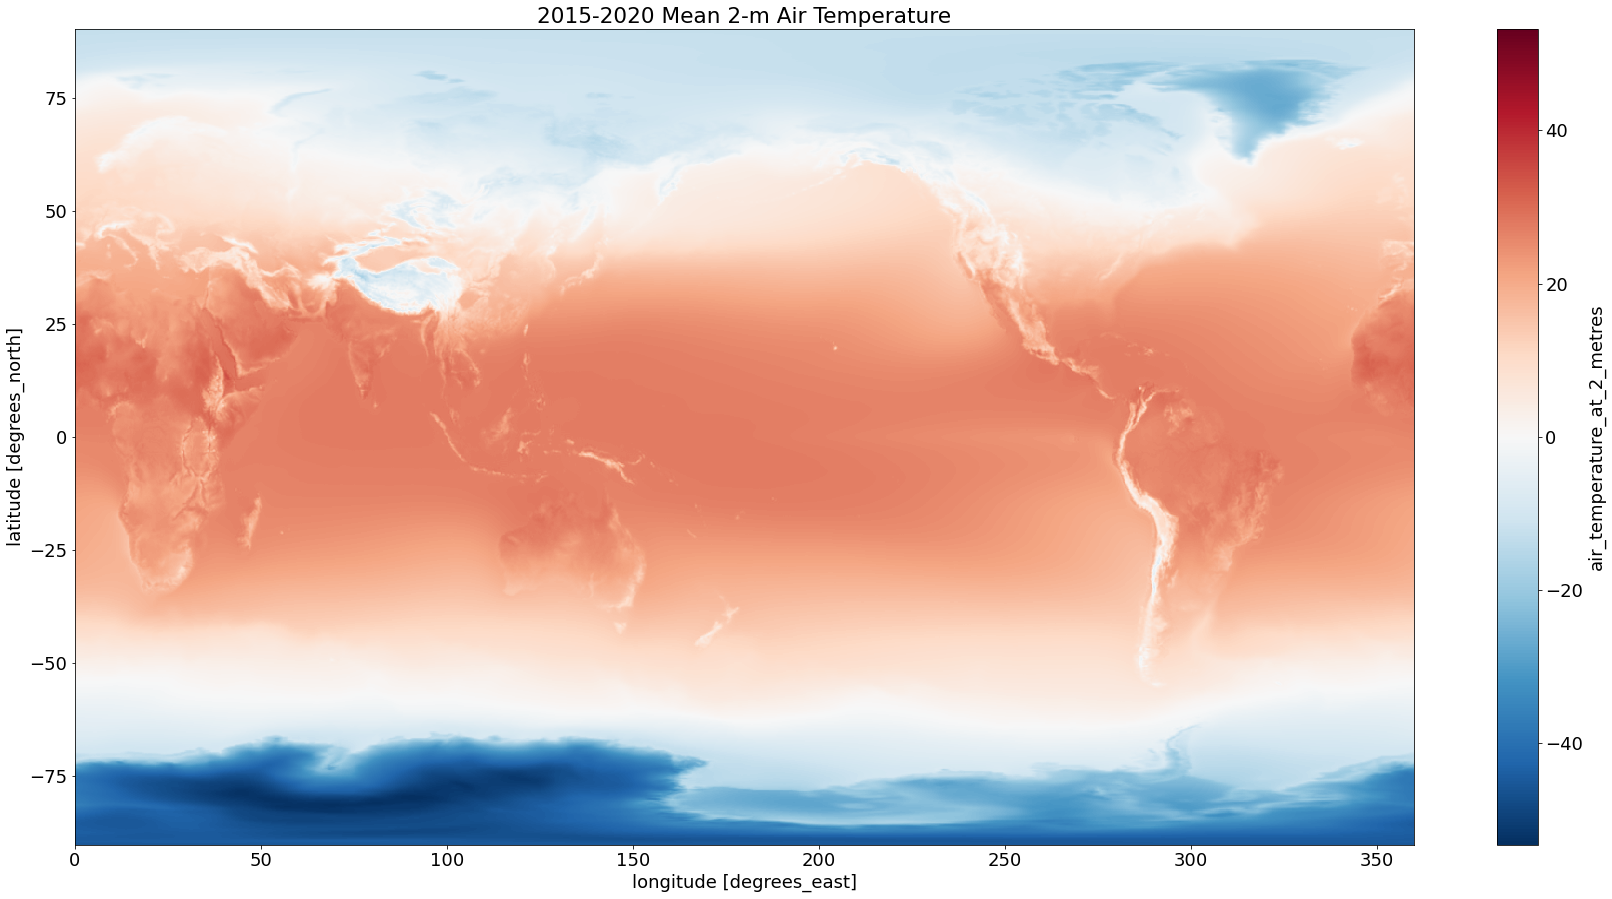

In [53]:
temp_mean.compute()
temp_mean.plot(figsize=(30, 15))
plt.title('2015-2020 Mean 2-m Air Temperature')

### Repeat for standard deviation

In [54]:
temp_std = ds['air_temperature_at_2_metres'].std(dim='time0')
temp_std

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<_sqrt, shape=(721, 1440), dtype=float32, chunksize=(400, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0

In [55]:
temp_std = temp_std.persist()
progress(temp_std)

VBox()

Text(0.5, 1.0, '2015-2020 Standard Deviation 2-m Air Temperature')

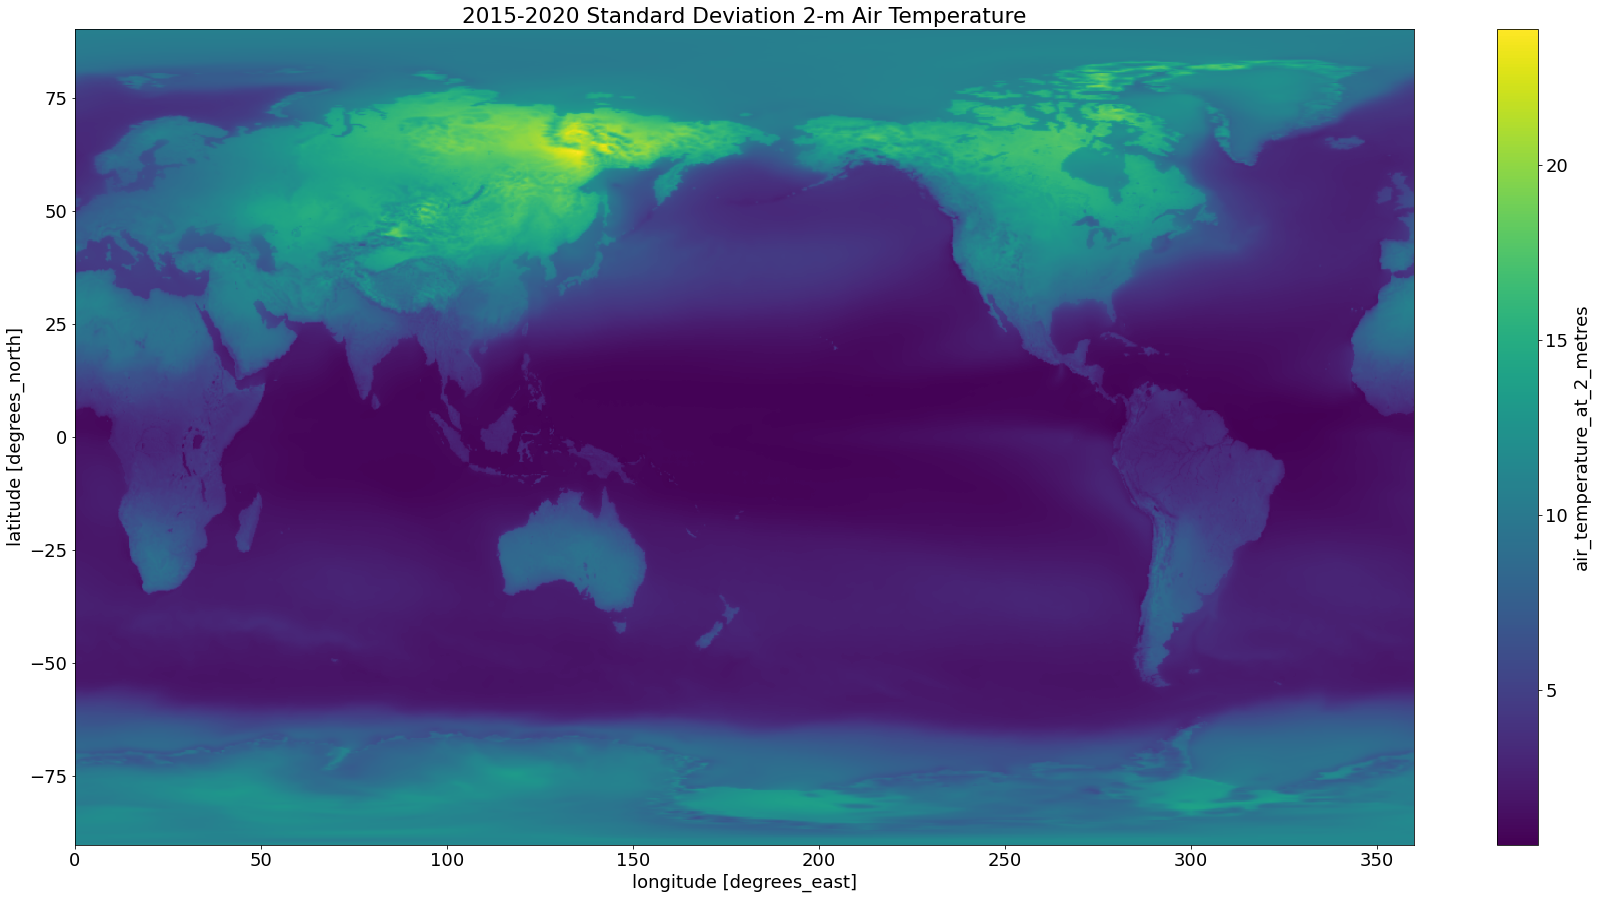

In [56]:
temp_std.compute()
temp_std.plot(figsize=(30, 15))
plt.title('2015-2020 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points

In [57]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
    {'name': 'Melbourne', 'lon': 144.95, 'lat': -37.84},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61},
 {'name': 'Melbourne', 'lon': 144.95, 'lat': -37.84}]

In [60]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'air_temperature_at_2_metres' : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Melbourne         (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>

In [61]:
ds_locs

<xarray.Dataset>
Dimensions:           (time0: 52608)
Coordinates:
  * time0             (time0) datetime64[ns] 2015-01-01 ... 2020-12-31T23:00:00
Data variables:
    Santa Barbara     (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Colorado Springs  (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Honolulu          (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Seattle           (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    Melbourne         (time0) float32 dask.array<chunksize=(720,), meta=np.ndarray>

### Convert to dataframe

In [62]:
df_f = ds_locs.to_dataframe()
df_f

,Santa Barbara,Colorado Springs,Honolulu,Seattle,Melbourne
time0,,,,,
2015-01-01 00:00:00,10.287506,-7.149994,21.725006,2.287506,20.100006
2015-01-01 01:00:00,9.475006,-11.337494,21.662506,1.162506,20.975006
2015-01-01 02:00:00,7.725006,-13.962494,21.600006,0.537506,20.725006
2015-01-01 03:00:00,6.350006,-15.087494,21.225006,-0.899994,21.850006
2015-01-01 04:00:00,5.225006,-17.399994,21.162506,-1.212494,22.787506
...,...,...,...,...,...
2020-12-31 19:00:00,11.537506,3.787506,24.350006,8.287506,15.412506
2020-12-31 20:00:00,11.850006,4.037506,24.412506,8.350006,16.600006
2020-12-31 21:00:00,12.850006,4.600006,24.287506,8.475006,18.100006


In [63]:
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle,Melbourne
count,52608.000000,52608.000000,52608.000000,52608.000000,52608.000000
mean,16.579418,9.001678,24.549555,11.893990,14.792746
std,5.417463,10.973804,1.536424,6.173346,6.149888
min,2.100006,-26.712494,17.037506,-9.899994,-0.899994
25%,12.412506,0.287506,23.475006,7.350006,10.475006
50%,16.537506,9.037506,24.662506,11.475006,13.787506
75%,20.537506,17.162506,25.725006,16.162506,18.225006
max,36.037506,36.850006,28.787506,33.475006,43.475006


## Plot temperature timeseries

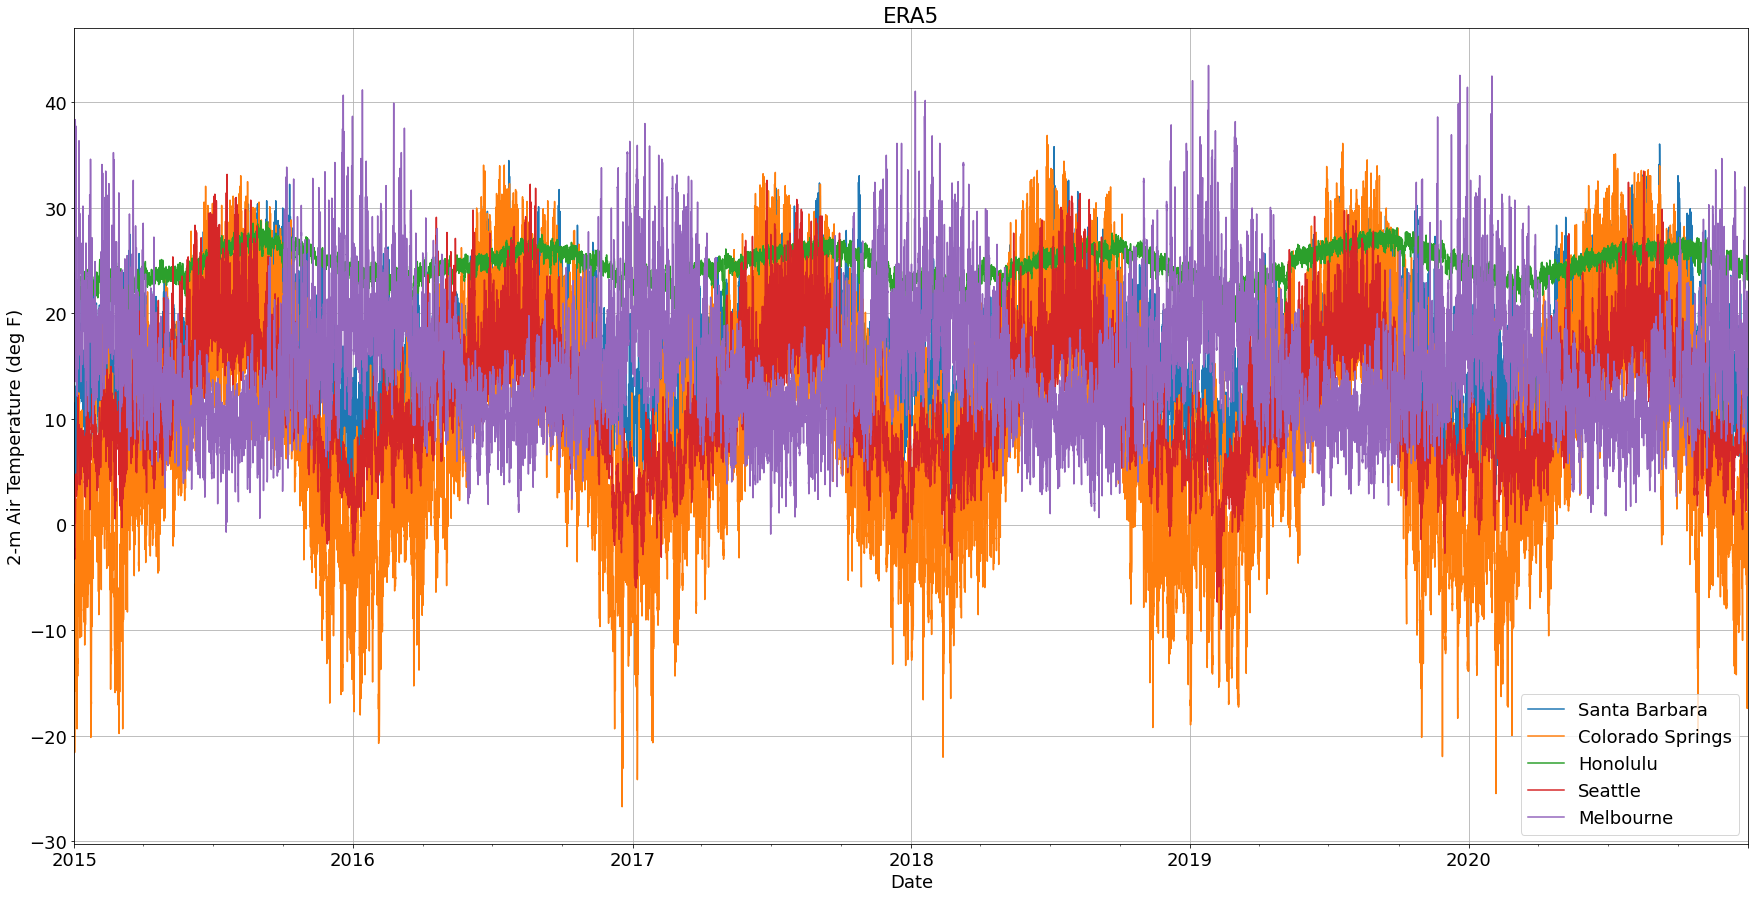

In [64]:
ax = df_f.plot(figsize=(30, 15), title="ERA5", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [ ]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])